In [1]:
%load_ext autoreload
import os,sys
import pandas as pd
import seaborn as sns
import numpy as np
import progressbar
import dill as pickle
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import logging

sys.path.append("../")

print(sys.path)

%autoreload 2
from src.pySRM.pysrm.regions import SpectraRegion, ProteinWeights
%autoreload 2
from src.pySRM.pysrm.imzml import IMZMLExtract
%autoreload 2
from src.pySRM.pysrm.comparative import CombinedSpectra

loggers = [logging.getLogger(name) for name in logging.root.manager.loggerDict]
for logger in loggers:
    logger.setLevel(logging.INFO)

['/mnt/f/dev/git/pyIMS/examples', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/usr/local/lib/python3.8/dist-packages', '/usr/local/lib/python3.8/dist-packages/mpld3-0.3.1.dev1-py3.8.egg', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.8/dist-packages/IPython/extensions', '/home/mjoppich/.ipython', '../']


Load an imzML file

In [2]:
imze = IMZMLExtract("/mnt/d/dev/data/msi/slideD/181114_AT1_Slide_D_Proteins.imzML")

Opening regions file for /mnt/d/dev/data/msi/slideD/181114_AT1_Slide_D_Proteins.imzML


Explore which regions are there?

0 ((356, 400, 215, 273), 2655)
1 ((436, 478, 632, 687), 2408)
2 ((1572, 1612, 608, 666), 2419)
3 ((1149, 1197, 142, 205), 3136)
4 ((618, 666, 211, 266), 2744)
5 ((633, 684, 630, 688), 3068)
6 ((1357, 1400, 628, 686), 2596)


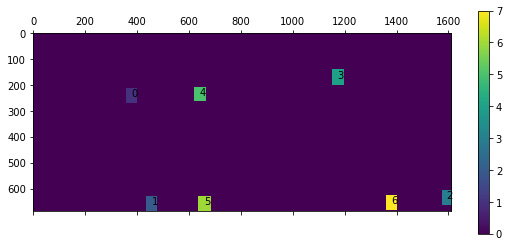

{0: ((356, 400, 215, 273), 2655),
 1: ((436, 478, 632, 687), 2408),
 2: ((1572, 1612, 608, 666), 2419),
 3: ((1149, 1197, 142, 205), 3136),
 4: ((618, 666, 211, 266), 2744),
 5: ((633, 684, 630, 688), 3068),
 6: ((1357, 1400, 628, 686), 2596)}

In [3]:
imze.list_regions()

Start with prozessing the first region , region 0

In [ ]:
spectra0_orig = imze.get_region_array(0, makeNullLine=True)
spectra0_intra = imze.normalize_region_array(spectra0_orig, normalize="intra_median")
spectra0 = imze.normalize_region_array(spectra0_intra, normalize="inter_median")

In [ ]:
spectra1_orig = imze.get_region_array(1, makeNullLine=True)
spectra1_intra = imze.normalize_region_array(spectra1_orig, normalize="intra_median")
spectra1 = imze.normalize_region_array(spectra1_intra, normalize="inter_median")

In [ ]:
imze.plot_fcs(spectra0_orig, [(5,30),(10,30),(20,30),(25,30),(35,30),(40,30)])

In [ ]:
imze.plot_fcs(spectra0_intra, [(5,30),(10,30),(20,30),(25,30),(35,30),(40,30)])

In [ ]:
imze.plot_fcs(spectra0, [(5,30),(10,30),(20,30),(25,30),(35,30),(40,30)])

In [ ]:
imze.plot_fcs(spectra1_orig, [(5,30),(10,30),(20,30),(25,30),(35,30),(40,30)])

In [ ]:
imze.plot_fcs(spectra1_intra, [(5,30),(10,30),(20,30),(25,30),(35,30),(40,30)])

In [ ]:
imze.plot_fcs(spectra1, [(5,30),(10,30),(20,30),(25,30),(35,30),(40,30)])

We can now ensure that the normalized spectra are indeed comparable.

Where are the highest peaks? This may give a hint on whether or not a normalization by max intensity would also have worked. => here: most probably yes!

In [ ]:
imze.list_highest_peaks(spectra0, counter=True)

Let's plot the norm of each spectrum

In [ ]:
imze.plot_tnc(spectra0)

It can be seen that the norm of the spectra differs. However, given that intensities should be comparable, and that there was sample everywhere => just continue

In [ ]:
spec = SpectraRegion(spectra0, imze.mzValues)

In [ ]:
spec.calculate_similarity(mode="spectra_log")

There are various (unsupervised) clustering techniques. Like UMAP+HDBSCAN

In [ ]:
spec.segment(method="UMAP_DBSCAN", number_of_regions=15, min_cluster_size=9, num_samples=1000)

In [ ]:
spec.redo_hdbscan_on_dimred(number_of_regions=15, min_cluster_size=9, num_samples=500)

In [ ]:
len(spec.dimred_labels)

In [ ]:
mpl.rcParams['figure.figsize'] = (10,6)
spec.vis_umap(legend=True)
mpl.rcParams['figure.figsize'] = (6,4)

In [ ]:
spec.plot_segments()

In [ ]:
spec.filter_clusters(method='remove_singleton')
spec.filter_clusters(method='merge_background')
spec.filter_clusters(method='remove_islands')

In [ ]:
spec.plot_segments()

Which may or may not work well - more robustly, and maybe faster is a classic clustering of the similarity scores:

In [ ]:
spec.segment(method="WARD", number_of_regions=15)

In [ ]:
spec.plot_segments()

In [ ]:
spec.filter_clusters(method='remove_singleton')
spec.filter_clusters(method='merge_background')
spec.filter_clusters(method='remove_islands')

In [ ]:
spec.plot_segments()

A manual curation of the segmentation is still possible!

In [ ]:
spec.segmented[0:6,] = 0

In [ ]:
spec.plot_segments()

Consensus Analysis

In [ ]:
spec.consensus_spectra()

In [ ]:
spec.consensus_similarity()

In [ ]:
spec.plot_consensus_similarity()

In [ ]:
spec.plot_consensus_similarity(mode="spectra")

All clusters hare a 95% similarity in median. Cluster 0 (background) is the most heterogeneous one.

In [ ]:
#spec.plot_inter_consensus_similarity()

# Differential Analysis

One of the stand-alone features of pyIMS is the integration with differential expression analysis. Here several key-features are presented.

First, single masses are looked at:

In [ ]:
spec.mass_heatmap(14954, min_cut_off=0.0025)

The mass with m/z-value 14954 apparently is most active within the aorta structure (center of the image). Is this specific to a specific cluster

In [ ]:
dfobj = spec.mass_dabest(14954)

The DABEST-Plot also clearly reveals that in contrast to the background, cluster 8 intensity values for this mass are quite higher than for all other clusters.

Abviously this mass is most intense in Cluster 8, but also cluster 14. We can now take a look at this mass by setting cluster 14 as reference cluster

In [ ]:
spec.mass_dabest(14954, background=14)

Not knowing where this cluster 8 is, we can highlight it specifically:

In [ ]:
spec.plot_segments(highlight=8)

Or together with cluster 14, where this mass is also prevalent.

On a sidenote: background is set to 0, other regions == 1, and the target region is set to 2

In [ ]:
spec.plot_segments(highlight=[8,11])

Just for the sake of clarity: we now remove all differential expression results!

In [ ]:
spec.clear_de_results()

## Protein m/z to name

For any combination of sequencing results with these IMS analyses, knowing which protein was measured is of interest.

Using a previously performed LC-MS/MS experiment, which delivers detected proteins together with the masses, allows an easy translation of m/z values to protein name.
This work is done in the ProteinWeights object.

In [13]:
pw = ProteinWeights("protein_weights.tsv")

2020-10-01 10:19:23,279  ProteinWeights  INFO: Loaded a total of 5371 proteins with 5341 masses


In [40]:
pw.print_collisions(print_proteins=False)

2020-10-01 10:43:14,176  ProteinWeights  INFO:          Number of total proteins: 5371
2020-10-01 10:43:14,176  ProteinWeights  INFO:          Number of total proteins: 5371
2020-10-01 10:43:14,177  ProteinWeights  INFO:            Number of total masses: 5341
2020-10-01 10:43:14,177  ProteinWeights  INFO:            Number of total masses: 5341
2020-10-01 10:43:14,178  ProteinWeights  INFO: Number of proteins with collision: 1485
2020-10-01 10:43:14,178  ProteinWeights  INFO: Number of proteins with collision: 1485
2020-10-01 10:43:14,180  ProteinWeights  INFO:         Mean Number of Collidings: 1.2552188552188552
2020-10-01 10:43:14,180  ProteinWeights  INFO:         Mean Number of Collidings: 1.2552188552188552
2020-10-01 10:43:14,181  ProteinWeights  INFO:       Median Number of Collidings: 1.2552188552188552
2020-10-01 10:43:14,181  ProteinWeights  INFO:       Median Number of Collidings: 1.2552188552188552


In [39]:
pw.print_collisions(maxdist=1.0, print_proteins=False)

2020-10-01 10:43:02,510  ProteinWeights  INFO:          Number of total proteins: 5371
2020-10-01 10:43:02,510  ProteinWeights  INFO:          Number of total proteins: 5371
2020-10-01 10:43:02,511  ProteinWeights  INFO:            Number of total masses: 5341
2020-10-01 10:43:02,511  ProteinWeights  INFO:            Number of total masses: 5341
2020-10-01 10:43:02,512  ProteinWeights  INFO: Number of proteins with collision: 1119
2020-10-01 10:43:02,512  ProteinWeights  INFO: Number of proteins with collision: 1119
2020-10-01 10:43:02,513  ProteinWeights  INFO:         Mean Number of Collidings: 1.2100089365504916
2020-10-01 10:43:02,513  ProteinWeights  INFO:         Mean Number of Collidings: 1.2100089365504916
2020-10-01 10:43:02,515  ProteinWeights  INFO:       Median Number of Collidings: 1.2100089365504916
2020-10-01 10:43:02,515  ProteinWeights  INFO:       Median Number of Collidings: 1.2100089365504916


In [58]:
pw_theo = ProteinWeights("protein_weights.theo.tsv", max_mass=30010)

2020-10-01 10:54:39,539  ProteinWeights  INFO: Loaded a total of 7283 proteins with 10191 masses
2020-10-01 10:54:39,539  ProteinWeights  INFO: Loaded a total of 7283 proteins with 10191 masses
2020-10-01 10:54:39,539  ProteinWeights  INFO: Loaded a total of 7283 proteins with 10191 masses


In [59]:
pw_theo.print_collisions(print_proteins=False)

2020-10-01 10:54:45,850  ProteinWeights  INFO:          Number of total proteins: 7283
2020-10-01 10:54:45,850  ProteinWeights  INFO:          Number of total proteins: 7283
2020-10-01 10:54:45,850  ProteinWeights  INFO:          Number of total proteins: 7283
2020-10-01 10:54:45,851  ProteinWeights  INFO:            Number of total masses: 10191
2020-10-01 10:54:45,851  ProteinWeights  INFO:            Number of total masses: 10191
2020-10-01 10:54:45,851  ProteinWeights  INFO:            Number of total masses: 10191
2020-10-01 10:54:45,852  ProteinWeights  INFO: Number of proteins with collision: 6316
2020-10-01 10:54:45,852  ProteinWeights  INFO: Number of proteins with collision: 6316
2020-10-01 10:54:45,852  ProteinWeights  INFO: Number of proteins with collision: 6316
2020-10-01 10:54:45,855  ProteinWeights  INFO:         Mean Number of Collidings: 2.8738125395820138
2020-10-01 10:54:45,855  ProteinWeights  INFO:         Mean Number of Collidings: 2.8738125395820138
2020-10-01 1

In [60]:
pw_theo.print_collisions(maxdist=1.0, print_proteins=False)

2020-10-01 10:54:54,221  ProteinWeights  INFO:          Number of total proteins: 7283
2020-10-01 10:54:54,221  ProteinWeights  INFO:          Number of total proteins: 7283
2020-10-01 10:54:54,221  ProteinWeights  INFO:          Number of total proteins: 7283
2020-10-01 10:54:54,223  ProteinWeights  INFO:            Number of total masses: 10191
2020-10-01 10:54:54,223  ProteinWeights  INFO:            Number of total masses: 10191
2020-10-01 10:54:54,223  ProteinWeights  INFO:            Number of total masses: 10191
2020-10-01 10:54:54,224  ProteinWeights  INFO: Number of proteins with collision: 4881
2020-10-01 10:54:54,224  ProteinWeights  INFO: Number of proteins with collision: 4881
2020-10-01 10:54:54,224  ProteinWeights  INFO: Number of proteins with collision: 4881
2020-10-01 10:54:54,226  ProteinWeights  INFO:         Mean Number of Collidings: 1.9096496619545176
2020-10-01 10:54:54,226  ProteinWeights  INFO:         Mean Number of Collidings: 1.9096496619545176
2020-10-01 1

With the m/z->protein object we can now find all marker masses for the 15 detected regions

For example we can also try to find out, which protein corresponds to mass 14954 ! (it's Ifitm3 ...)

In [19]:
pw.get_protein_from_mass(14954)

[('Ifitm3', 14954.0)]

In [20]:
pw_theo.get_protein_from_mass(14954)

[('Tnfrsf12a', 14952.97469999999), ('Ifitm3', 14954.185999999994)]

{2257.5839,
 8927.188999999998,
 30240.013400000025,
 33037.03710000002,
 40233.347700000035,
 44032.78440000003,
 44451.46180000004,
 45477.38780000004,
 48313.85780000006,
 50982.752300000066,
 51110.88150000007,
 52189.072400000085,
 55078.22360000007,
 57618.98890000011,
 57747.11810000011,
 57875.24730000012,
 102224.47280000069,
 139017.76520000066}

2020-10-01 11:06:33,879  SpectraRegion  INFO: Processing Mass 19494.35879999999 with best existing mass 19493.942202125156


19494.35879999999 [('Ccl27a', 19494.35879999999)]


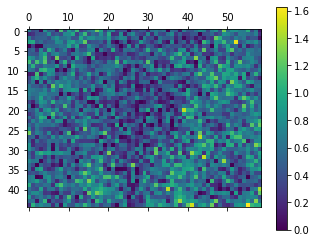

2020-10-01 11:06:33,996  SpectraRegion  INFO: Processing Mass 10099.632999999985 with best existing mass 10099.587949181696


10099.632999999985 [('Ccl27a', 10099.632999999985), ('Chchd7', 10101.449999999995)]


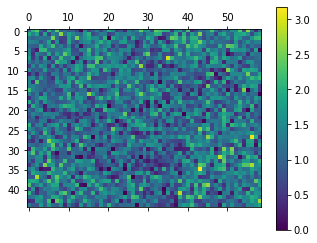

2020-10-01 11:06:34,132  SpectraRegion  INFO: Processing Mass 14651.815799999984 with best existing mass 14651.133720567635


14651.815799999984 [('Ccl27a', 14651.815799999984), ('Vbp1', 14652.91139999998)]


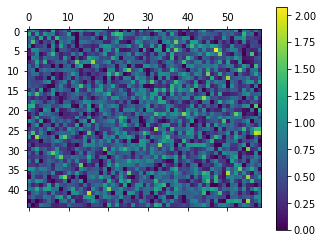

2020-10-01 11:06:34,479  SpectraRegion  INFO: Processing Mass 12579.54569999998 with best existing mass 12579.09381867344


12579.54569999998 [('Ccl19', 12579.54569999998)]


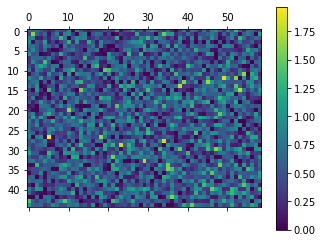

2020-10-01 11:06:34,601  SpectraRegion  INFO: Processing Mass 14557.82079999998 with best existing mass 14557.567461341532


14557.82079999998 [('Ccl21a', 14557.82079999998)]


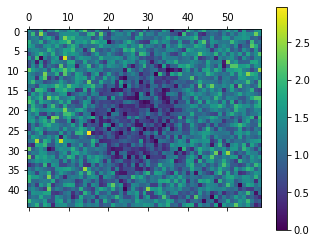

2020-10-01 11:06:34,721  SpectraRegion  INFO: Processing Mass 15271.877899999985 with best existing mass 15271.387471243903


15271.877899999985 [('Il11', 15271.877899999985)]


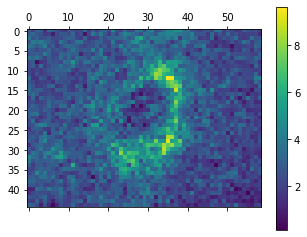

2020-10-01 11:06:34,839  SpectraRegion  INFO: Processing Mass 13065.960899999984 with best existing mass 13066.543846577173


13065.960899999984 [('Il7', 13065.960899999984)]


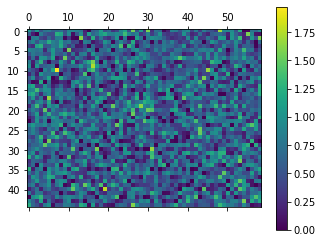

2020-10-01 11:06:34,959  SpectraRegion  INFO: Processing Mass 4892.7843 with best existing mass 4893.078363213031


4892.7843 [('Il2ra', 4892.7843)]


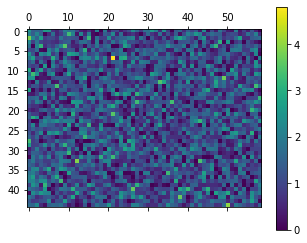

2020-10-01 11:06:35,070  SpectraRegion  INFO: Processing Mass 12904.570899999993 with best existing mass 12905.066592751478


12904.570899999993 [('Il15ra', 12904.570899999993), ('Cav2', 12905.530399999985)]


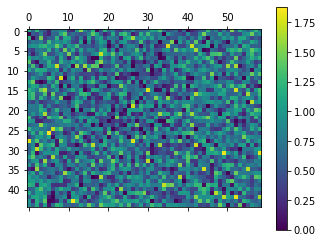

2020-10-01 11:06:35,189  SpectraRegion  INFO: Processing Mass 18122.08549999999 with best existing mass 18122.14011121341


18122.08549999999 [('Il15ra', 18122.08549999999), ('Msh3', 18122.3698)]


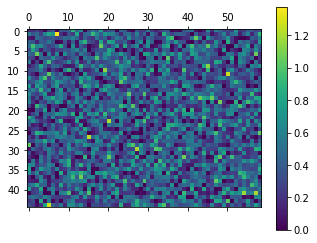

2020-10-01 11:06:35,304  SpectraRegion  INFO: Processing Mass 21365.61989999999 with best existing mass 21365.26738664723


21365.61989999999 [('Il15ra', 21365.61989999999), ('Epo', 21364.868400000014)]


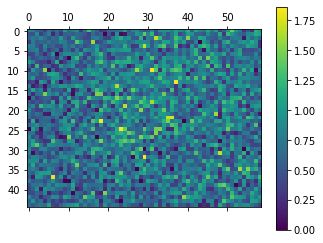

2020-10-01 11:06:35,416  SpectraRegion  INFO: Processing Mass 11161.56199999999 with best existing mass 11162.017731361968


11161.56199999999 [('Il15ra', 11161.56199999999), ('Rbis', 11162.921699999992)]


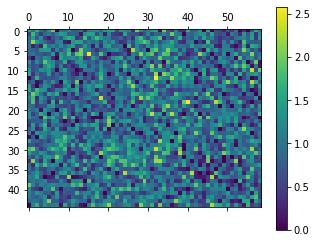

2020-10-01 11:06:35,523  SpectraRegion  INFO: Processing Mass 21687.485200000006 with best existing mass 21688.22189429862


21687.485200000006 [('Il3ra', 21687.485200000006)]


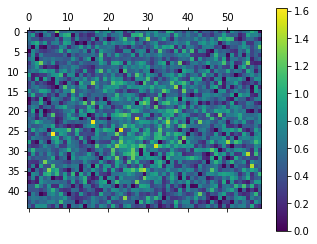

2020-10-01 11:06:35,643  SpectraRegion  INFO: Processing Mass 26612.208100000018 with best existing mass 26612.523569375648


26612.208100000018 [('Il22ra2', 26612.208100000018)]


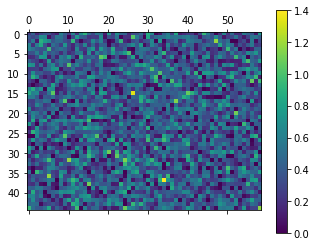

2020-10-01 11:06:35,759  SpectraRegion  INFO: Processing Mass 17490.081799999993 with best existing mass 17489.81329483055


17490.081799999993 [('Il17a', 17490.081799999993)]


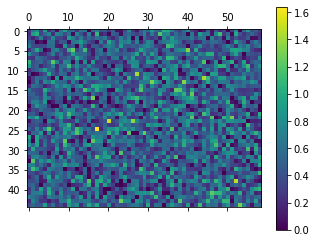

2020-10-01 11:06:35,893  SpectraRegion  INFO: Processing Mass 18279.695999999993 with best existing mass 18279.089965399136


18279.695999999993 [('Il1rn', 18279.695999999993)]


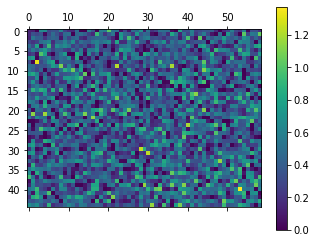

2020-10-01 11:06:36,017  SpectraRegion  INFO: Processing Mass 5903.754799999999 with best existing mass 5904.197616140279


5903.754799999999 [('Il1rn', 5903.754799999999)]


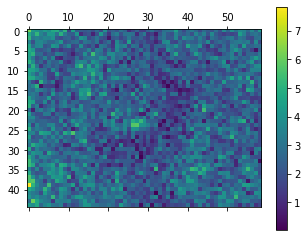

2020-10-01 11:06:36,130  SpectraRegion  INFO: Processing Mass 13626.99059999998 with best existing mass 13626.43226872047


13626.99059999998 [('Cxcl17', 13626.99059999998), ('Wfdc10', 13626.576499999985)]


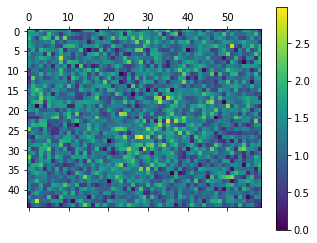

2020-10-01 11:06:36,247  SpectraRegion  INFO: Processing Mass 18202.5728 with best existing mass 18202.1241715196


18202.5728 [('Il17rd', 18202.5728)]


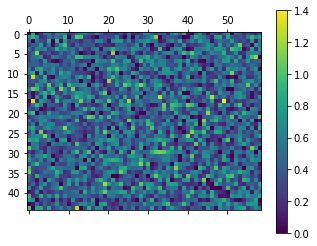

2020-10-01 11:06:36,359  SpectraRegion  INFO: Processing Mass 23928.884999999987 with best existing mass 23929.28471608513


23928.884999999987 [('Ilrun', 23928.884999999987), ('Stradb', 23930.18550000001)]


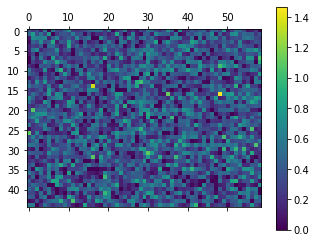

2020-10-01 11:06:36,468  SpectraRegion  INFO: Processing Mass 24900.095199999996 with best existing mass 24899.657372252623


24900.095199999996 [('Ilrun', 24900.095199999996)]


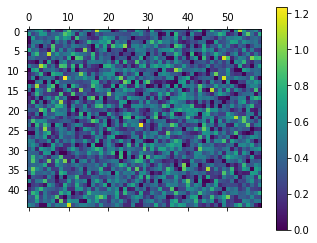

2020-10-01 11:06:36,579  SpectraRegion  INFO: Processing Mass 29990.628199999992 with best existing mass 29989.96370079532


29990.628199999992 [('Il33', 29990.628199999992), ('Gnas', 29991.278499999975)]


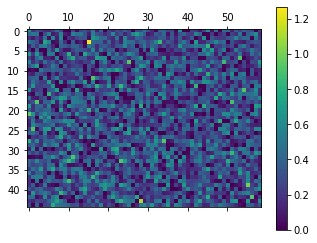

2020-10-01 11:06:36,693  SpectraRegion  INFO: Processing Mass 23789.840400000016 with best existing mass 23790.444460459297


23789.840400000016 [('Il6', 23789.840400000016)]


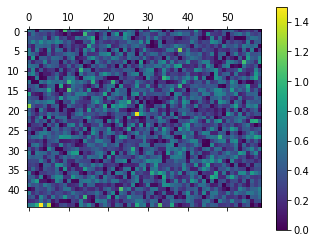

2020-10-01 11:06:36,811  SpectraRegion  INFO: Processing Mass 24383.67730000004 with best existing mass 24383.53381329573


24383.67730000004 [('Il6', 24383.67730000004), ('Trappc4', 24384.7599)]


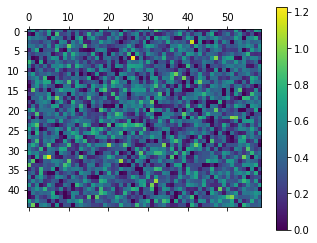

2020-10-01 11:06:36,928  SpectraRegion  INFO: Processing Mass 19399.816999999995 with best existing mass 19400.375942899052


19399.816999999995 [('Il2', 19399.816999999995)]


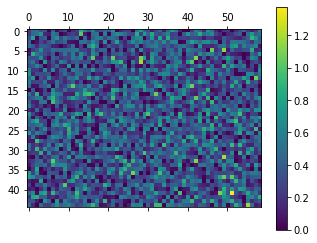

2020-10-01 11:06:37,040  SpectraRegion  INFO: Processing Mass 16810.60699999999 with best existing mass 16810.70334883464


16810.60699999999 [('Il21', 16810.60699999999)]


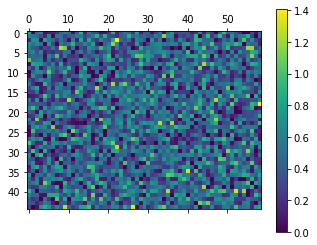

2020-10-01 11:06:37,159  SpectraRegion  INFO: Processing Mass 8872.763199999998 with best existing mass 8872.66264674908


8872.763199999998 [('Il18', 8872.763199999998), ('Ss18l2', 8873.036699999993)]


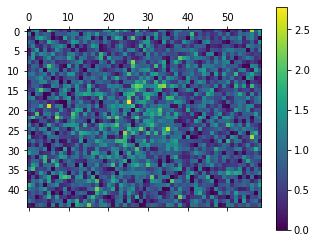

2020-10-01 11:06:37,264  SpectraRegion  INFO: Processing Mass 22149.901800000007 with best existing mass 22150.016657575838


22149.901800000007 [('Il18', 22149.901800000007), ('Bhlha15', 22149.542699999965)]


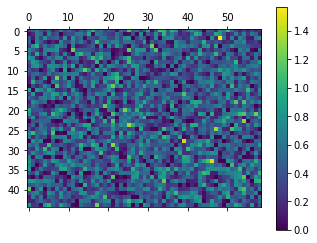

2020-10-01 11:06:37,373  SpectraRegion  INFO: Processing Mass 5272.061099999999 with best existing mass 5271.870799757418


5272.061099999999 [('Il4', 5272.061099999999)]


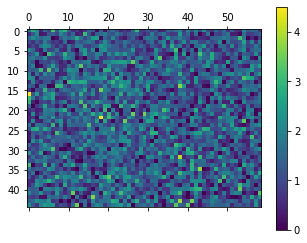

2020-10-01 11:06:37,674  SpectraRegion  INFO: Processing Mass 14107.345999999974 with best existing mass 14107.845763770905


14107.345999999974 [('Il13', 14107.345999999974), ('Tnfrsf18', 14106.149199999985)]


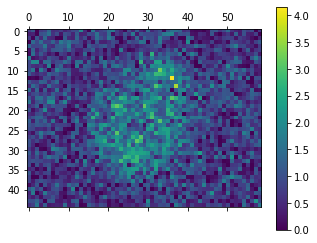

2020-10-01 11:06:37,783  SpectraRegion  INFO: Processing Mass 15409.923999999985 with best existing mass 15410.227726869734


15409.923999999985 [('Il5', 15409.923999999985)]


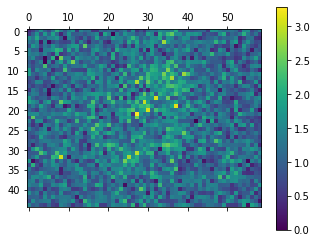

2020-10-01 11:06:37,890  SpectraRegion  INFO: Processing Mass 18540.14679999999 with best existing mass 18540.17001130423


18540.14679999999 [('Il3', 18540.14679999999)]


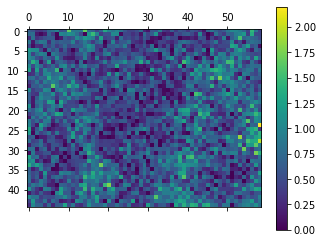

2020-10-01 11:06:38,012  SpectraRegion  INFO: Processing Mass 6986.472600000002 with best existing mass 6986.246130093767


6986.472600000002 [('Cxcl14', 6986.472600000002)]


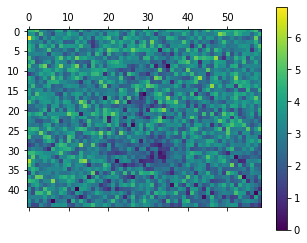

2020-10-01 11:06:38,138  SpectraRegion  INFO: Processing Mass 22348.43089999998 with best existing mass 22347.713108521315


22348.43089999998 [('Il17d', 22348.43089999998), ('Fgf7', 22346.767500000016)]


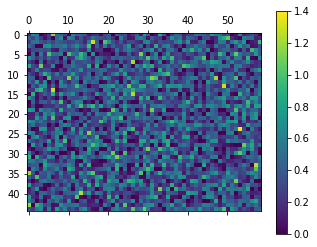

2020-10-01 11:06:38,248  SpectraRegion  INFO: Processing Mass 20308.54879999999 with best existing mass 20308.874137320254


20308.54879999999 [('Il17b', 20308.54879999999), ('Il17c', 20308.787899999992)]


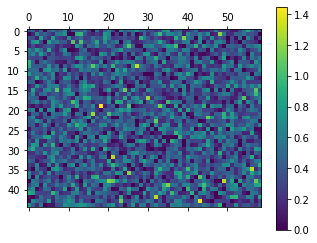

2020-10-01 11:06:38,353  SpectraRegion  INFO: Processing Mass 24178.823800000006 with best existing mass 24178.29169628363


24178.823800000006 [('Il12a', 24178.823800000006), ('Ankrd55', 24177.100800000022)]


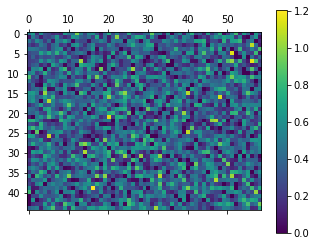

26204.00270000001 [('Prss2', 26203.25329999999), ('Il12a', 26204.00270000001)]


2020-10-01 11:06:38,454  SpectraRegion  INFO: Processing Mass 26204.00270000001 with best existing mass 26203.548468564775


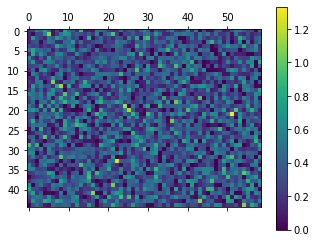

26895.941099999996

2020-10-01 11:06:38,561  SpectraRegion  INFO: Processing Mass 26895.941099999996 with best existing mass 26896.240613480608


 [('Cxcl16', 26895.941099999996)]


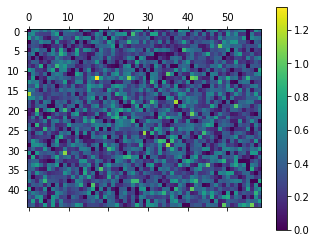

2020-10-01 11:06:38,675  SpectraRegion  INFO: Processing Mass 16325.812299999983 with best existing mass 16326.271587357554


16325.812299999983 [('Fam183b', 16327.27959999999), ('Ccl2', 16325.812299999983)]


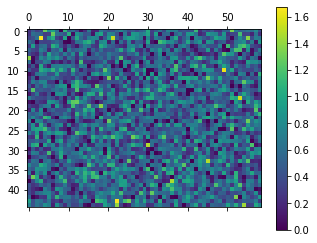

2020-10-01 11:06:38,787  SpectraRegion  INFO: Processing Mass 10892.872099999986 with best existing mass 10893.392019390252


10892.872099999986 [('Fam216b', 10891.48299999999), ('Ccl11', 10892.872099999986)]


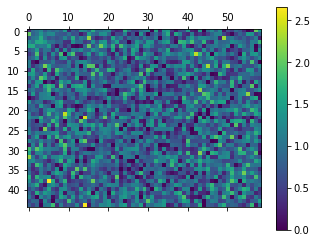

2020-10-01 11:06:38,898  SpectraRegion  INFO: Processing Mass 11658.704599999988 with best existing mass 11658.522558545646


11658.704599999988 [('Pate3', 11659.626499999986), ('Ccl12', 11658.704599999988)]


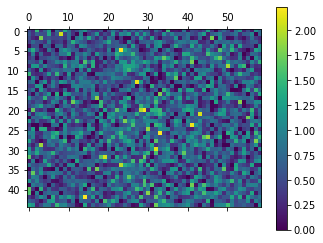

2020-10-01 11:06:39,010  SpectraRegion  INFO: Processing Mass 11017.193999999998 with best existing mass 11017.140942882841


11017.193999999998 [('Eif4ebp3', 11018.495599999993), ('Ccl8', 11017.193999999998)]


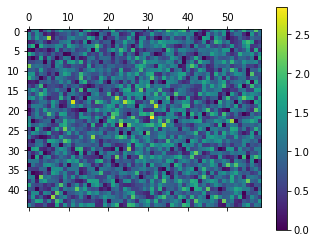

2020-10-01 11:06:39,129  SpectraRegion  INFO: Processing Mass 10754.69929999999 with best existing mass 10754.55176376442


10754.69929999999 [('Ccl20', 10754.69929999999)]


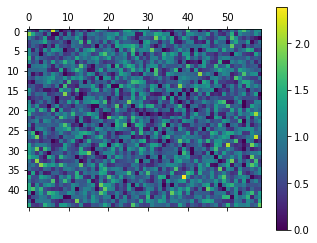

2020-10-01 11:06:39,246  SpectraRegion  INFO: Processing Mass 13870.752799999982 with best existing mass 13870.911849278998


13870.752799999982 [('Ccl9', 13870.752799999982)]


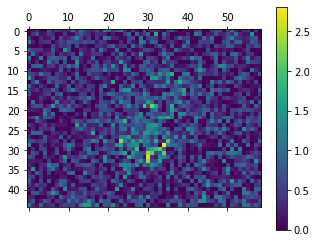

2020-10-01 11:06:39,354  SpectraRegion  INFO: Processing Mass 10167.716399999996 with best existing mass 10167.498943781287


10167.716399999996 [('Rad54b', 10169.499699999991), ('Ccl4', 10167.716399999996)]


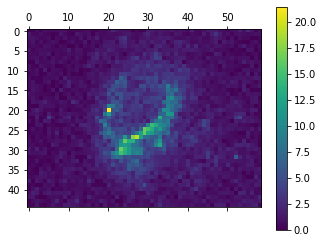

2020-10-01 11:06:39,473  SpectraRegion  INFO: Processing Mass 10254.250199999993 with best existing mass 10253.51953694077


10254.250199999993 [('Cxcl1', 10254.250199999993)]


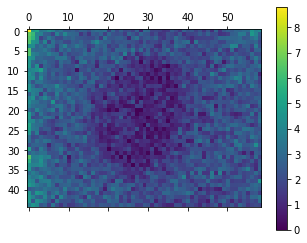

2020-10-01 11:06:39,589  SpectraRegion  INFO: Processing Mass 10620.574399999989 with best existing mass 10620.238907778563


10620.574399999989 [('Gm525', 10620.183199999994), ('Cxcl2', 10620.574399999989)]


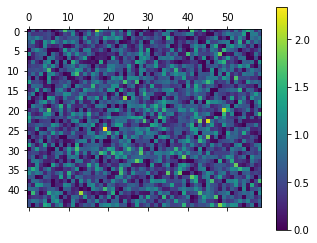

2020-10-01 11:06:39,698  SpectraRegion  INFO: Processing Mass 10788.802299999987 with best existing mass 10789.261827670878


10788.802299999987 [('Zfp866', 10789.753199999994), ('Cxcl10', 10788.802299999987)]


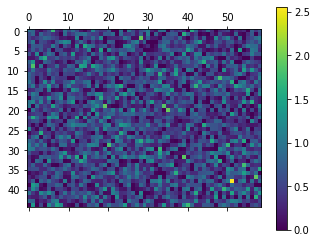

2020-10-01 11:06:39,816  SpectraRegion  INFO: Processing Mass 11152.35079999999 with best existing mass 11152.962932082024


11152.35079999999 [('Cxcl11', 11152.35079999999)]


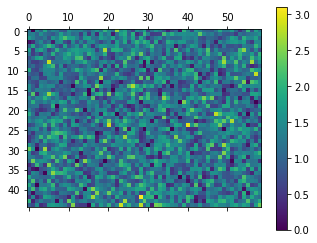

2020-10-01 11:06:39,928  SpectraRegion  INFO: Processing Mass 11538.699599999984 with best existing mass 11539.301034693031


11538.699599999984 [('Crem', 11537.28529999999), ('Ccl17', 11538.699599999984)]


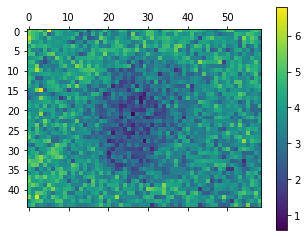

2020-10-01 11:06:40,049  SpectraRegion  INFO: Processing Mass 21899.871200000005 with best existing mass 21899.500544164013


21899.871200000005 [('Psmb1', 21900.825699999972), ('Il18bp', 21899.871200000005)]


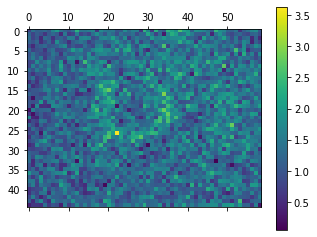

2020-10-01 11:06:40,167  SpectraRegion  INFO: Processing Mass 26763.888900000027 with best existing mass 26763.43689070807


26763.888900000027 [('Il34', 26763.888900000027)]


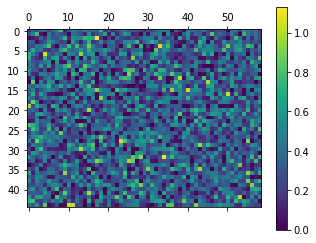

2020-10-01 11:06:40,279  SpectraRegion  INFO: Processing Mass 18538.088100000008 with best existing mass 18538.66087809091


18538.088100000008 [('Il6st', 18538.088100000008), ('Mfap5', 18537.995099999996)]


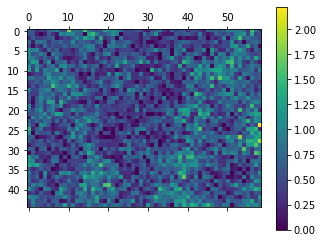

2020-10-01 11:06:40,385  SpectraRegion  INFO: Processing Mass 7292.779600000001 with best existing mass 7292.600172398589


7292.779600000001 [('Il6st', 7292.779600000001)]


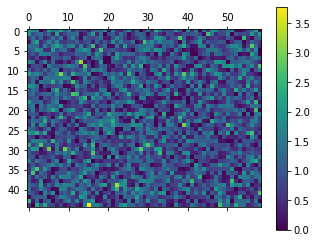

2020-10-01 11:06:40,496  SpectraRegion  INFO: Processing Mass 10560.59809999999 with best existing mass 10559.873579245592


10560.59809999999 [('Mrps21', 10561.238699999993), ('Cxcl12', 10560.59809999999)]


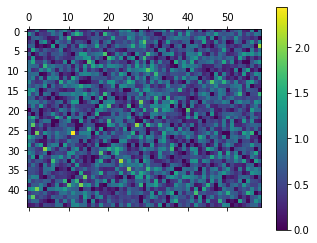

2020-10-01 11:06:40,788  SpectraRegion  INFO: Processing Mass 13634.183899999978 with best existing mass 13633.977934787092


13634.183899999978 [('Ube2a', 13635.07789999999), ('Cxcl12', 13634.183899999978)]


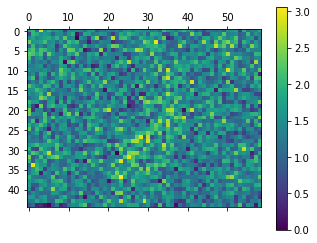

2020-10-01 11:06:40,905  SpectraRegion  INFO: Processing Mass 10031.886499999991 with best existing mass 10031.676954582104


10031.886499999991 [('Tnfrsf12a', 10032.82969999999), ('Cxcl12', 10031.886499999991)]


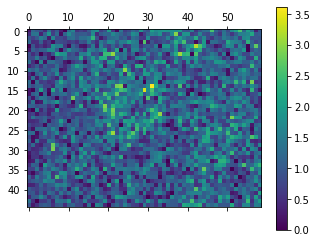

2020-10-01 11:06:41,020  SpectraRegion  INFO: Processing Mass 14569.692699999976 with best existing mass 14569.640527048126


14569.692699999976 [('Ccl28', 14569.692699999976), ('Trmt2b', 14568.390499999981)]


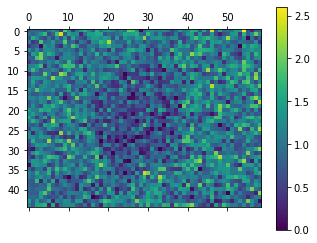

2020-10-01 11:06:41,132  SpectraRegion  INFO: Processing Mass 20308.787899999992 with best existing mass 20308.874137320254


20308.787899999992 [('Il17b', 20308.54879999999), ('Il17c', 20308.787899999992)]


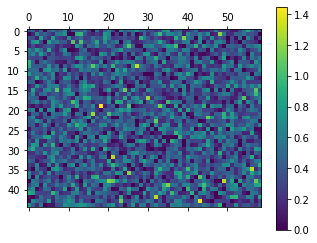

2020-10-01 11:06:41,242  SpectraRegion  INFO: Processing Mass 11199.70799999999 with best existing mass 11199.746061695076


11199.70799999999 [('Ss18l2', 11201.606299999994), ('Il31', 11199.70799999999)]


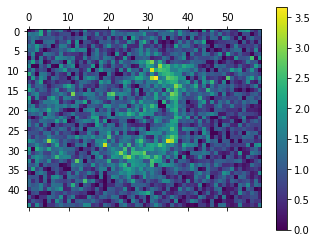

2020-10-01 11:06:41,349  SpectraRegion  INFO: Processing Mass 18119.635499999997 with best existing mass 18119.121844786765


18119.635499999997 [('Tpo', 18119.2567), ('Il31', 18119.635499999997)]


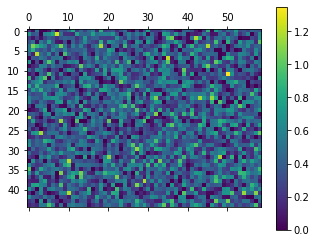

2020-10-01 11:06:41,457  SpectraRegion  INFO: Processing Mass 20872.213499999998 with best existing mass 20871.780825890197


20872.213499999998 [('Il24', 20872.213499999998)]


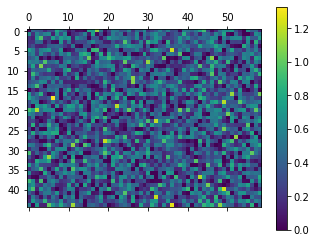

2020-10-01 11:06:41,570  SpectraRegion  INFO: Processing Mass 17542.508099999995 with best existing mass 17542.6329572969


17542.508099999995 [('Arl14epl', 17540.928299999996), ('Il20', 17542.508099999995)]


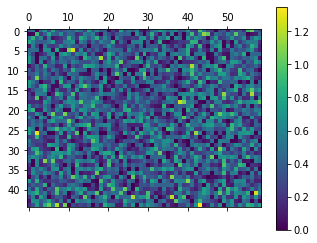

2020-10-01 11:06:41,682  SpectraRegion  INFO: Processing Mass 11672.063399999986 with best existing mass 11672.104757465566


11672.063399999986 [('Il19', 11672.063399999986)]


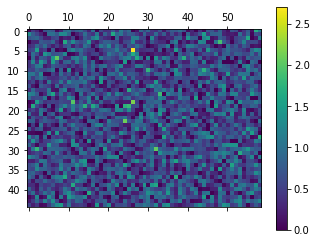

2020-10-01 11:06:41,790  SpectraRegion  INFO: Processing Mass 20287.34260000001 with best existing mass 20287.746272333712


20287.34260000001 [('Il19', 20287.34260000001)]


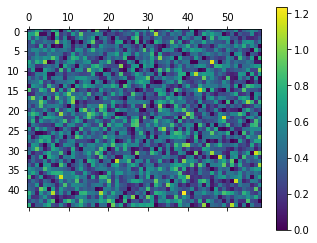

2020-10-01 11:06:41,897  SpectraRegion  INFO: Processing Mass 22536.800200000012 with best existing mass 22536.354760186845


22536.800200000012 [('Sult2a2', 22538.584699999978), ('Ildr2', 22536.800200000012)]


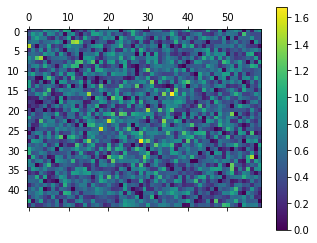

In [70]:
for y in pw_theo.protein2mass:
    if not y.startswith(("Ccl", "Ccr", "Cxc", "Il")):
        continue
    for x in pw_theo.get_masses_for_protein(y):
        massprots = pw_theo.get_protein_from_mass(x)
        
        if len(massprots) <= 2:
            print(x, massprots)
            slided_0.mass_heatmap(x)
            

2020-10-01 10:55:57,023  SpectraRegion  INFO: Processing Mass 13870 with best existing mass 13869.402716065675


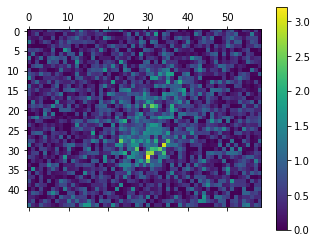

array([[0.        , 0.33562942, 0.29980934, ..., 0.08112048, 0.57262519,
        0.        ],
       [0.02545898, 0.28970706, 0.69557764, ..., 1.32654748, 0.20488023,
        0.10190447],
       [0.3632469 , 0.17660935, 0.16031279, ..., 0.66523704, 0.66826813,
        0.07720524],
       ...,
       [0.31846044, 0.3063842 , 0.13660394, ..., 0.6416831 , 0.39386746,
        0.42146079],
       [0.35692512, 0.74327409, 0.        , ..., 0.33920547, 0.06606368,
        0.6278585 ],
       [1.12895917, 0.37550086, 0.18109881, ..., 0.37619895, 0.84541711,
        0.65886899]])

In [65]:
slided_0.mass_heatmap(Ccl9)

Marker masses/proteins/genes are genes which are differentially regulated when compared to the specific cluster and all other clusters (including or excluding the background cluster).

Making the distinction regarding the background cluster might be required if the target tissue is embedded in another tissue. Excluding the background might then deliver more sensitive results.

In [ ]:
mgenes = spec.find_all_markers(pw, includeBackground=False,
                               replaceExisting=False,
                               outdirectory="./deresults/",
                               use_methods=["ttest", "rank"])

In [ ]:
mgenes["ttest"]

In [ ]:
mgenes_bg = spec.find_all_markers(pw, includeBackground=True, replaceExisting=False, use_methods = ["ttest", "rank"])

After both find_all_markers runs we can list all DE results, which are then printed.
Each row shows one contained DE results beginning with the test performed and then a tuple of two region/cluster IDs. In the first row here:

a t-test was performed on cluster 9 versus clusters 8,10,11,12,13,14,15 .

In [ ]:
spec.list_de_results()

It's also easy to save the result to disk:

In [ ]:
markerGenes = mgenes["ttest"]
markerGenes.to_csv("deresults/marker_genes.tsv", sep="\t", index=False)

In [ ]:
markerGenesBG = mgenes_bg["ttest"]
markerGenesBG.to_csv("deresults/marker_genes_bg.tsv", sep="\t", index=False)

In [ ]:
print("Number of unique, differentially detected proteins (from masses): {}".format(len(set(mgenes["ttest"]["gene"]))))

In [ ]:
print("Number of unique, differentially detected proteins (from masses): {}".format(len(set(mgenes_bg["ttest"]["gene"]))))

In order to save the results, the SpectraRegion object can be pickled:

In [ ]:
with open("slideD_region_0.spec.pickle", "wb") as fout:
    pickle.dump(spec, fout)

# Cell-type detection

Cell-type detection requires analyseMarkers.py from https://github.com/mjoppich/scrnaseq_celltype_prediction .

One (obvious) question is: what can I do with those marker proteins? Well, a lot!

First, these are the proteins which you are interested in: these define your clusters, because they are present.

Second, these proteins give a clue about which cell types might be present, if cell-type specific genes were found.

Using the scrnaseq-celltype-prediction tool, this can be analysed! Let's download it first (requires wget, python3 and several other libraries - maybe).
Did you know? This tool achieves better predictions than SingleR :)

Because we know what kind of sample we got (aorta embedded in liver), we can specify organs to specifically check for cell types.
Organs to be considered are "Connective tissue" "Vasculature" "Heart" "Skeletal Muscle" "Smooth muscle" "Immune system" "Blood" "Epithelium" "Liver".
This allows a context-specific evaluation!

In [ ]:
! ls analyseMarkers.py

In [ ]:
! wget https://raw.githubusercontent.com/mjoppich/scrnaseq_celltype_prediction/master/analyseMarkers.py

In [ ]:
! python3 analyseMarkers.py --organs "Connective tissue" "Vasculature" "Heart" "Skeletal Muscle" "Smooth muscle" "Immune system" "Blood" "Epithelium" "Liver" --pvaladj qvalue --markers deresults/marker_genes.tsv -n 2

This is quite interesting. For cluster 8 this tool predicts mainly monocytes or gamma delta t cells - cells which do not migrate into other tissues.

This makes sense, because one would expect these cell-types in the inner of the vessel.

H2AFX is known to be upregulated in lymphoblasts (check wikipedia ;) ).
Ifitm3 is highly expressed in both, Liver and Monocytes: https://www.proteinatlas.org/ENSG00000142089-IFITM3/tissue (Consensus dataset)

In [ ]:
spec.plot_segments(highlight=(8))

In [ ]:
! python3 analyseMarkers.py --organs "Connective tissue" "Vasculature" "Heart" "Skeletal Muscle" "Smooth muscle" "Immune system" "Blood" "Epithelium" "Liver" --pvaladj qvalue --markers deresults/marker_genes_bg.tsv -n 2

In this analysis, the background was kept in. More differential genes are found, but also more liver-related cell types are found.

This suggests that the analysis which includes the liver background has influenced the found differential proteins too much.

Nonetheless, the results remain consistent. For cluster 8, the missing monocytes are replaced by hepatocytes, which are monocyte-like cells residing in the liver.

Cluster 9 showing high amounds of cardiomyocytes is also not unlikely, given its location at the outer area of the aorta.

In [ ]:
spec.plot_segments(highlight=(9))

Finally the SpectraRegion can also be exported to Aorta3D.

In [ ]:
#spec.to_aorta3d("./slided_test/", "slided", 0, protWeights=pw, nodf=False, pathPrefix="../data/test_msi/")

In [ ]:
!ls slided_test

# Preparations for CombinedSpectra - A comparative analysis

In [ ]:
spectra1 = imze.get_region_array(1, makeNullLine=True)
imze.normalize_region_array(spectra1, normalize="vector")
imze.list_highest_peaks(spectra1, counter=True)
print("Got spectra", spectra1.shape)

spec1 = SpectraRegion(spectra1, imze.mzValues)
spec1.calculate_similarity(mode="spectra_log_dist")
spec1.segment(method="WARD", number_of_regions=15)
spec1.plot_segments()

So far the results were only for one IMS sample.

Now the idea is to integrate multiple samples, in order to compare the different samples which were measured on the same slide.

Hence the remaining samples are processed, all in the same fashion. With the inter and intro normalization, the sample are made comparable.

In [4]:
pw = ProteinWeights("protein_weights.tsv")

def process_imzeregion(imze, regionID, basename):
    
    print("Processing regionID", regionID, "for basename", basename)
    
    spectra_orig = imze.get_region_array(regionID, makeNullLine=True)
    spectra_intra = imze.normalize_region_array(spectra_orig, normalize="intra_median")
    spectra = imze.normalize_region_array(spectra_intra, normalize="inter_median")
    
    rspec = SpectraRegion(spectra, imze.mzValues, name=basename + "_" + str(regionID))
    rspec.calculate_similarity(mode="spectra_log_dist")
    rspec.segment(method="WARD", number_of_regions=15)
    rspec.plot_segments()
    
    rspec.filter_clusters(method='remove_singleton')
    rspec.filter_clusters(method='merge_background')
    rspec.filter_clusters(method='remove_islands')
    rspec.filter_clusters(method='remove_islands', minIslandSize=15)
    rspec.plot_segments()
    
    #rspec.consensus_spectra()
    #rspec.consensus_similarity()
    #rspec.plot_consensus_similarity()
    
    mgenes = None
    mgenes_bg = None
    mgenes = rspec.find_all_markers(pw, includeBackground=False, replaceExisting=False, use_methods = ["ttest", "rank"])
    mgenes_bg = rspec.find_all_markers(pw, includeBackground=True, replaceExisting=False, use_methods = ["ttest", "rank"])
    
    return rspec, mgenes, mgenes_bg
    

First set the logging level to warn, to remove too many messages ...

In [ ]:
#loggers = [logging.getLogger(name) for name in logging.root.manager.loggerDict]
#for logger in loggers:
#    logger.setLevel(logging.WARN)

Fetching region range
Fetching region shape
Found region 0 with shape (45, 59, 17900)
Fetching region spectra
  5% (135 of 2655) |#                    | Elapsed Time: 0:00:00 ETA:   0:00:03

Processing regionID 0 for basename slideD


100% (2655 of 2655) |####################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (2655 of 2655) |####################| Elapsed Time: 0:00:00 Time:  0:00:00
Started Log Value: 0.14000733569264412
100% (45 of 45) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
Got 2655 median-enabled pixels
5-Number stats for medians: (2655, 2655, 0.2905536462232088, 0.5712127712945096, 0.6654297160132764, 0.7571640240536153, 1.119313296797138)
Started Log Value: 0.21725614592432976
100% (45 of 45) |########################| Elapsed Time: 0:00:17 Time:  0:00:17
Got a total of 47524500 fold changes
Median elements [23762250]
Median elements
Global Median 0.64579
2020-09-30 22:41:10,939  SpectraRegion  INFO: dimensions inputarray: 17900
2020-09-30 22:41:10,939  SpectraRegion  INFO: Creating C++ obj
2020-09-30 22:41:10,940  SpectraRegion  INFO: 17900 (45, 59, 17900)
2020-09-30 22:41:10,940  SpectraRegion  INFO: dimensions 17900
2020-09-30 22:41:10,941  SpectraRegion  INFO: input dimensio

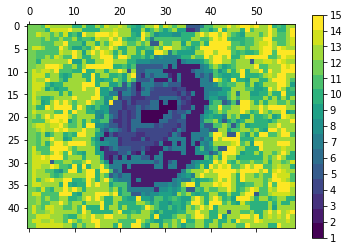

2020-09-30 22:42:35,211  SpectraRegion  INFO: Assigning clusters to background: {10, 11, 12, 13, 14, 15}


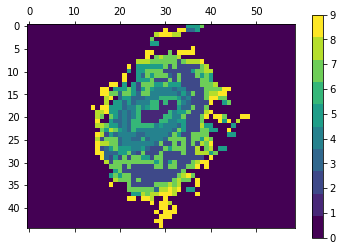

2020-09-30 22:42:35,308  SpectraRegion  INFO: DE data for case: [5]
2020-09-30 22:42:35,309  SpectraRegion  INFO: DE data for control: [7, 9, 3, 8, 2, 4, 6, 1]
2020-09-30 22:42:35,309  SpectraRegion  INFO: Running [5] against [7, 9, 3, 8, 2, 4, 6, 1]
2020-09-30 22:42:35,310  SpectraRegion  INFO: DE result key: ((5,), (1, 2, 3, 4, 6, 7, 8, 9))
2020-09-30 22:42:35,664  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 725)
2020-09-30 22:42:35,667  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (725, 3)
2020-09-30 22:42:35,670  SpectraRegion  INFO: Performing DE-test: ttest
/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
2020-09-30 22:42:35,933  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((5,), (1, 2, 3, 4, 6, 7, 8, 9))
2020-09-30 22:42:35,934  SpectraRegion  INFO: Performing DE-test: rank
2020-09-30 22:4

Processing regionID 1 for basename slideD


100% (2408 of 2408) |####################| Elapsed Time: 0:00:04 Time:  0:00:04
100% (2408 of 2408) |####################| Elapsed Time: 0:00:00 Time:  0:00:00
Started Log Value: 0.17063884288072587
100% (43 of 43) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
Got 2408 median-enabled pixels
5-Number stats for medians: (2408, 2408, 0.3039763115205163, 0.5889737648019792, 0.6580512343895084, 0.7246390240951075, 1.0161616910876121)
Started Log Value: 0.2648863598704338
100% (43 of 43) |########################| Elapsed Time: 0:00:15 Time:  0:00:15
Got a total of 43103200 fold changes
Median elements [21551600]
Median elements
Global Median 0.64556
2020-09-30 22:48:00,321  SpectraRegion  INFO: dimensions inputarray: 17900
2020-09-30 22:48:00,322  SpectraRegion  INFO: Creating C++ obj
2020-09-30 22:48:00,322  SpectraRegion  INFO: 17900 (43, 56, 17900)
2020-09-30 22:48:00,323  SpectraRegion  INFO: dimensions 17900
2020-09-30 22:48:00,324  SpectraRegion  INFO: input dimensio

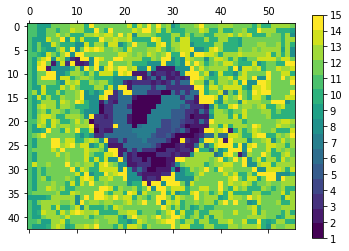

2020-09-30 22:49:11,718  SpectraRegion  INFO: Assigning clusters to background: {8, 9, 10, 11, 12, 13, 14}


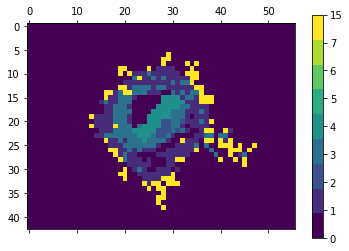

2020-09-30 22:49:11,815  SpectraRegion  INFO: DE data for case: [15]
2020-09-30 22:49:11,816  SpectraRegion  INFO: DE data for control: [2, 6, 3, 1, 7, 5, 4]
2020-09-30 22:49:11,817  SpectraRegion  INFO: Running [15] against [2, 6, 3, 1, 7, 5, 4]
2020-09-30 22:49:11,817  SpectraRegion  INFO: DE result key: ((15,), (1, 2, 3, 4, 5, 6, 7))
2020-09-30 22:49:11,998  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 485)
2020-09-30 22:49:12,000  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (485, 3)
2020-09-30 22:49:12,004  SpectraRegion  INFO: Performing DE-test: ttest
2020-09-30 22:49:12,165  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((15,), (1, 2, 3, 4, 5, 6, 7))
2020-09-30 22:49:12,166  SpectraRegion  INFO: Performing DE-test: rank
2020-09-30 22:49:16,161  SpectraRegion  INFO: DE-test (rank) finished. Results available: ((15,), (1, 2, 3, 4, 5, 6, 7))
2020-09-30 22:49:16,163  SpectraRegion  INFO: DE result for case ((15,), (1, 2, 3, 4, 5, 6, 7)) with (

In [5]:
slided_0, slided0_mgenes, slided0_mgenes_bg = process_imzeregion(imze=imze, regionID= 0, basename="slideD")
slided_1, slided1_mgenes, slided1_mgenes_bg = process_imzeregion(imze=imze, regionID= 1, basename="slideD")

In [ ]:
slided_0.mass_dabest(pw.protein2mass.get("Tmsb4x"))

In [ ]:
slided_1.mass_dabest(pw.protein2mass.get("Tmsb4x"))

Fetching region range
Fetching region shape
Found region 4 with shape (49, 56, 17900)
Fetching region spectra
  2% (70 of 2744) |                      | Elapsed Time: 0:00:00 ETA:   0:00:04

Processing regionID 4 for basename slideD


100% (2744 of 2744) |####################| Elapsed Time: 0:00:04 Time:  0:00:04
100% (2744 of 2744) |####################| Elapsed Time: 0:00:00 Time:  0:00:00
Started Log Value: 0.22751572877168655
100% (49 of 49) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
Got 2744 median-enabled pixels
5-Number stats for medians: (2744, 2744, 0.29120835853070265, 0.5888907621230302, 0.660637862228705, 0.7270544871043271, 0.9875144181541924)
Started Log Value: 0.3518995396792889
100% (49 of 49) |########################| Elapsed Time: 0:00:22 Time:  0:00:22
Got a total of 49117600 fold changes
Median elements [24558800]
Median elements
Global Median 0.64784
2020-09-30 22:53:40,667  SpectraRegion  INFO: dimensions inputarray: 17900
2020-09-30 22:53:40,667  SpectraRegion  INFO: Creating C++ obj
2020-09-30 22:53:40,668  SpectraRegion  INFO: 17900 (49, 56, 17900)
2020-09-30 22:53:40,668  SpectraRegion  INFO: dimensions 17900
2020-09-30 22:53:40,669  SpectraRegion  INFO: input dimensio

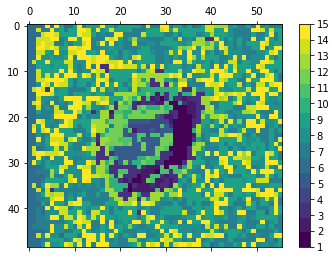

2020-09-30 22:55:15,622  SpectraRegion  INFO: Assigning clusters to background: {6, 7, 8, 9, 14, 15}


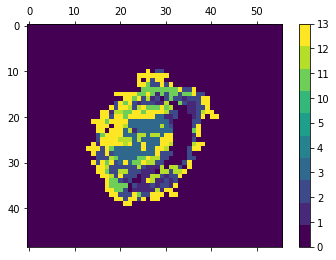

2020-09-30 22:55:15,720  SpectraRegion  INFO: DE data for case: [13]
2020-09-30 22:55:15,721  SpectraRegion  INFO: DE data for control: [3, 10, 12, 2, 11, 1, 5, 4]
2020-09-30 22:55:15,721  SpectraRegion  INFO: Running [13] against [3, 10, 12, 2, 11, 1, 5, 4]
2020-09-30 22:55:15,722  SpectraRegion  INFO: DE result key: ((13,), (1, 2, 3, 4, 5, 10, 11, 12))
2020-09-30 22:55:15,938  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 526)
2020-09-30 22:55:15,941  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (526, 3)
2020-09-30 22:55:15,945  SpectraRegion  INFO: Performing DE-test: ttest
2020-09-30 22:55:16,106  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((13,), (1, 2, 3, 4, 5, 10, 11, 12))
2020-09-30 22:55:16,106  SpectraRegion  INFO: Performing DE-test: rank
2020-09-30 22:55:20,246  SpectraRegion  INFO: DE-test (rank) finished. Results available: ((13,), (1, 2, 3, 4, 5, 10, 11, 12))
2020-09-30 22:55:20,249  SpectraRegion  INFO: DE result for case ((13,),

Processing regionID 5 for basename slideD


100% (3068 of 3068) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (3068 of 3068) |####################| Elapsed Time: 0:00:00 Time:  0:00:00
Started Log Value: 0.22961045652627946
100% (52 of 52) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
Got 3068 median-enabled pixels
5-Number stats for medians: (3068, 3068, 0.3318104865334491, 0.5890882557317825, 0.6596343025206233, 0.728007829747179, 0.9846777519403345)
Started Log Value: 0.35571027994155885
100% (52 of 52) |########################| Elapsed Time: 0:00:24 Time:  0:00:24
Got a total of 54917200 fold changes
Median elements [27458600]
Median elements
Global Median 0.64714
2020-09-30 23:01:10,064  SpectraRegion  INFO: dimensions inputarray: 17900
2020-09-30 23:01:10,065  SpectraRegion  INFO: Creating C++ obj
2020-09-30 23:01:10,066  SpectraRegion  INFO: 17900 (52, 59, 17900)
2020-09-30 23:01:10,066  SpectraRegion  INFO: dimensions 17900
2020-09-30 23:01:10,066  SpectraRegion  INFO: input dimensio

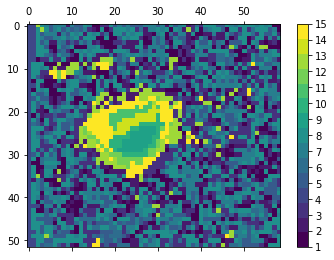

2020-09-30 23:03:06,991  SpectraRegion  INFO: Assigning clusters to background: {1, 2, 3, 4, 5, 6, 7, 8, 13}


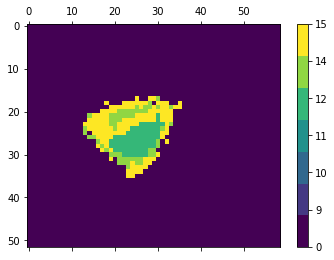

2020-09-30 23:03:07,090  SpectraRegion  INFO: DE data for case: [15]
2020-09-30 23:03:07,090  SpectraRegion  INFO: DE data for control: [12, 11, 14, 10, 9]
2020-09-30 23:03:07,091  SpectraRegion  INFO: Running [15] against [12, 11, 14, 10, 9]
2020-09-30 23:03:07,092  SpectraRegion  INFO: DE result key: ((15,), (9, 10, 11, 12, 14))
2020-09-30 23:03:07,187  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 253)
2020-09-30 23:03:07,189  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (253, 3)
2020-09-30 23:03:07,192  SpectraRegion  INFO: Performing DE-test: ttest
2020-09-30 23:03:07,287  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((15,), (9, 10, 11, 12, 14))
2020-09-30 23:03:07,288  SpectraRegion  INFO: Performing DE-test: rank
2020-09-30 23:03:10,759  SpectraRegion  INFO: DE-test (rank) finished. Results available: ((15,), (9, 10, 11, 12, 14))
2020-09-30 23:03:10,762  SpectraRegion  INFO: DE result for case ((15,), (9, 10, 11, 12, 14)) with (17900, 7) re

In [6]:
slided_4, slided4_mgenes, slided4_mgenes_bg = process_imzeregion(imze=imze, regionID= 4, basename="slideD")
slided_5, slided5_mgenes, slided5_mgenes_bg = process_imzeregion(imze=imze, regionID= 5, basename="slideD")

In [ ]:
#loggers = [logging.getLogger(name) for name in logging.root.manager.loggerDict]
#for logger in loggers:
#    logger.setLevel(logging.INFO)

In [7]:
markerGenes0 = slided0_mgenes["ttest"]
markerGenes0.to_csv("deresults/marker_genes_region_0.tsv", sep="\t", index=False)
markerGenes1 = slided1_mgenes["ttest"]
markerGenes1.to_csv("deresults/marker_genes_region_1.tsv", sep="\t", index=False)
markerGenes4 = slided4_mgenes["ttest"]
markerGenes4.to_csv("deresults/marker_genes_region_4.tsv", sep="\t", index=False)
markerGenes5 = slided5_mgenes["ttest"]
markerGenes5.to_csv("deresults/marker_genes_region_5.tsv", sep="\t", index=False)


In [8]:
! python3 analyseMarkers.py --organs "Connective tissue" "Vasculature" "Heart" "Skeletal Muscle" "Smooth muscle" "Immune system" "Blood" "Epithelium" --pvaladj qvalue --markers deresults/marker_genes_region_0.tsv --aorta3d --output deresults/marker_genes_region_0.pred.tsv 
! python3 analyseMarkers.py --organs "Connective tissue" "Vasculature" "Heart" "Skeletal Muscle" "Smooth muscle" "Immune system" "Blood" "Epithelium" --pvaladj qvalue --markers deresults/marker_genes_region_1.tsv --aorta3d --output deresults/marker_genes_region_1.pred.tsv 
! python3 analyseMarkers.py --organs "Connective tissue" "Vasculature" "Heart" "Skeletal Muscle" "Smooth muscle" "Immune system" "Blood" "Epithelium" --pvaladj qvalue --markers deresults/marker_genes_region_4.tsv --aorta3d --output deresults/marker_genes_region_4.pred.tsv 
! python3 analyseMarkers.py --organs "Connective tissue" "Vasculature" "Heart" "Skeletal Muscle" "Smooth muscle" "Immune system" "Blood" "Epithelium" --pvaladj qvalue --markers deresults/marker_genes_region_5.tsv --aorta3d --output deresults/marker_genes_region_5.pred.tsv 

Setting number of predictions to 1
Taking value gene from gene
Taking value cluster from clusterID
Taking value logfc from avg_logFC
Taking value pvaladj from qvalue
Taking value expr-mean from mean
Taking value expressing-cell-count from num
Taking value cluster-cell-count from anum
Got 9 clusters.
Starting analysis
Loaded Databases
known genes 38
known (celltype, organ) 50
Setting number of predictions to 1
Taking value gene from gene
Taking value cluster from clusterID
Taking value logfc from avg_logFC
Taking value pvaladj from qvalue
Taking value expr-mean from mean
Taking value expressing-cell-count from num
Taking value cluster-cell-count from anum
Got 7 clusters.
Starting analysis
Loaded Databases
known genes 26
known (celltype, organ) 41
Setting number of predictions to 1
Taking value gene from gene
Taking value cluster from clusterID
Taking value logfc from avg_logFC
Taking value pvaladj from qvalue
Taking value expr-mean from mean
Taking value expressing-cell-count from num
T

In [11]:
slided_0.to_aorta3d("./aorta3d/slided/", "slided", 0, protWeights=pw, ctpred="deresults/marker_genes_region_0.pred.tsv")
slided_1.to_aorta3d("./aorta3d/slided/", "slided", 1, protWeights=pw, ctpred="deresults/marker_genes_region_1.pred.tsv")
slided_4.to_aorta3d("./aorta3d/slided/", "slided", 4, protWeights=pw, ctpred="deresults/marker_genes_region_4.pred.tsv")
slided_5.to_aorta3d("./aorta3d/slided/", "slided", 5, protWeights=pw, ctpred="deresults/marker_genes_region_5.pred.tsv")

2020-09-30 23:37:25,306  SpectraRegion  INFO: Cell-type assigned: 1 -> Monocytes;Immune system
2020-09-30 23:37:25,307  SpectraRegion  INFO: Cell-type assigned: 2 -> Megakaryocytes;Immune system
2020-09-30 23:37:25,308  SpectraRegion  INFO: Cell-type assigned: 4 -> Mast cells;Immune system
2020-09-30 23:37:25,308  SpectraRegion  INFO: Cell-type assigned: 5 -> Monocytes;Immune system
2020-09-30 23:37:25,309  SpectraRegion  INFO: Cell-type assigned: 6 -> Monocytes;Immune system
2020-09-30 23:37:25,309  SpectraRegion  INFO: Cell-type assigned: 7 -> Mast cells;Immune system
2020-09-30 23:37:25,309  SpectraRegion  INFO: Cell-type assigned: 8 -> Mast cells;Immune system
2020-09-30 23:37:25,310  SpectraRegion  INFO: Cell-type assigned: 9 -> Smooth muscle cells;Smooth muscle
2020-09-30 23:37:25,319  SpectraRegion  INFO: DE data for case: [0]
2020-09-30 23:37:25,320  SpectraRegion  INFO: DE data for control: [5, 7, 9, 3, 8, 2, 4, 6, 1]
2020-09-30 23:37:25,320  SpectraRegion  INFO: Running [0] a

In [ ]:
! python3 analyseMarkers.py --organs "Connective tissue" "Vasculature" "Heart" "Skeletal Muscle" "Smooth muscle" "Immune system" "Blood" "Epithelium" --pvaladj qvalue --markers deresults/marker_genes_region_0.tsv -n 2

In [ ]:
! python3 analyseMarkers.py --organs "Connective tissue" "Vasculature" "Heart" "Skeletal Muscle" "Smooth muscle" "Immune system" "Blood" "Epithelium" --pvaladj qvalue --markers deresults/marker_genes_region_1.tsv -n 2

In [ ]:
! python3 analyseMarkers.py --organs "Connective tissue" "Vasculature" "Heart" "Skeletal Muscle" "Smooth muscle" "Immune system" "Blood" "Epithelium" --pvaladj qvalue --markers deresults/marker_genes_region_4.tsv -n 2

In [ ]:
! python3 analyseMarkers.py --organs "Connective tissue" "Vasculature" "Heart" "Skeletal Muscle" "Smooth muscle" "Immune system" "Blood" "Epithelium" --pvaladj qvalue --markers deresults/marker_genes_region_5.tsv -n 2

From these cell type predictions it can be seen that mostly atherosclerosis relates cell types are showing up.

# Creating a CombinedSpectra

In [ ]:
slided_0.name = "slided_0"
slided_1.name = "slided_1"
slided_4.name = "slided_4"
slided_5.name = "slided_5"

In [ ]:
#slided_0 = SpectraRegion.from_pickle("slideD_region_0.pickle")
#slided_1 = SpectraRegion.from_pickle("slideD_region_1.pickle")
#slided_4 = SpectraRegion.from_pickle("slideD_region_4.pickle")
#slided_5 = SpectraRegion.from_pickle("slideD_region_5pickle")

Of course a SpectraRegion can also be re-processed to yield a more realistic clustering.

In [ ]:
slided_1.segment(method="WPGMA", number_of_regions=15)
slided_1.plot_segments()

slided_1.filter_clusters(method='remove_singleton')
slided_1.filter_clusters(method='merge_background')
slided_1.filter_clusters(method='remove_islands')
slided_1.filter_clusters(method='remove_islands', minIslandSize=15)



slided_1.plot_segments()

In [ ]:
mask = slided_1.segmented == 8
mask[0:22,: ] = False
mask[:,0:22 ] = False
slided_1.segmented[mask] = 15
slided_1.plot_segments()
slided_1.plot_segments(highlight=[15])

In [ ]:
slided_5.segment(method="WPGMA", number_of_regions=15)
slided_5.plot_segments()

slided_5.filter_clusters(method='remove_singleton')
slided_5.filter_clusters(method='merge_background')
slided_5.filter_clusters(method='remove_islands')
slided_5.filter_clusters(method='remove_islands', minIslandSize=15)
slided_5.plot_segments()

In [ ]:
slided_0.to_pickle("deresults/slideD_region_0.pickle")
slided_1.to_pickle("deresults/slideD_region_1.pickle")

In [ ]:
slided_4.to_pickle("deresults/slideD_region_4.pickle")
slided_5.to_pickle("deresults/slideD_region_5.pickle")

In [78]:
slided_0.to_aorta3d("./aorta3d/slided/", "slided", 0, protWeights=pw, ctpred="deresults/marker_genes_region_0.pred.tsv")
slided_1.to_aorta3d("./aorta3d/slided/", "slided", 1, protWeights=pw, ctpred="deresults/marker_genes_region_1.pred.tsv")
slided_4.to_aorta3d("./aorta3d/slided/", "slided", 4, protWeights=pw, ctpred="deresults/marker_genes_region_4.pred.tsv")
slided_5.to_aorta3d("./aorta3d/slided/", "slided", 5, protWeights=pw, ctpred="deresults/marker_genes_region_5.pred.tsv")

2020-10-01 18:53:10,097  SpectraRegion  INFO: Cell-type assigned: 1 -> Monocytes;Immune system
INFO:SpectraRegion:Cell-type assigned: 1 -> Monocytes;Immune system
2020-10-01 18:53:10,098  SpectraRegion  INFO: Cell-type assigned: 2 -> Megakaryocytes;Immune system
INFO:SpectraRegion:Cell-type assigned: 2 -> Megakaryocytes;Immune system
2020-10-01 18:53:10,099  SpectraRegion  INFO: Cell-type assigned: 4 -> Mast cells;Immune system
INFO:SpectraRegion:Cell-type assigned: 4 -> Mast cells;Immune system
2020-10-01 18:53:10,100  SpectraRegion  INFO: Cell-type assigned: 5 -> Monocytes;Immune system
INFO:SpectraRegion:Cell-type assigned: 5 -> Monocytes;Immune system
2020-10-01 18:53:10,101  SpectraRegion  INFO: Cell-type assigned: 6 -> Monocytes;Immune system
INFO:SpectraRegion:Cell-type assigned: 6 -> Monocytes;Immune system
2020-10-01 18:53:10,102  SpectraRegion  INFO: Cell-type assigned: 7 -> Mast cells;Immune system
INFO:SpectraRegion:Cell-type assigned: 7 -> Mast cells;Immune system
2020-10-

In [15]:
! python3 /mnt/f/dev/git/Aorta3D/files2model/register/register_pimz.py --id slided \
--files \
/mnt/f/dev/git/pyIMS/examples/aorta3d/slided/slided.1.info \
/mnt/f/dev/git/pyIMS/examples/aorta3d/slided/slided.0.info \
/mnt/f/dev/git/pyIMS/examples/aorta3d/slided/slided.4.info \
/mnt/f/dev/git/pyIMS/examples/aorta3d/slided/slided.5.info \
--output /mnt/f/dev/git/pyIMS/examples/aorta3d/slided/registered/slided_server.conf

2020-10-02 13:02:52.506568: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2020-10-02 13:02:52.506609: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
<frozen importlib._bootstrap>:219: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
/mnt/f/dev/git/pyIMS/examples/aorta3d/slided/slided.1.info
['region', 'path_upgma', 'info', 'segment_file']
/mnt/f/dev/git/pyIMS/examples/aorta3d/slided/slided.0.info
['region', 'path_upgma', 'info', 'segment_file']
/mnt/f/dev/git/pyIMS/examples/aorta3d/slided/slided.4.info
['region', 'path_upgma', 'info', 'segment_file']
/mnt/f/dev/git/pyIMS/examples/aorta3d/slided/slided.5.info
['region', 'path_upgma', 'info',

Here a CombinedSpectra is creates. This class allows to compare multiple SpectraRegions

In [ ]:
combSpec = CombinedSpectra({0: slided_0, 1: slided_1, 4: slided_4, 5: slided_5})

The consensus_smilarity() function calculates the similarity between all the contained spectra's regions using the average cluster/region spectra.

In [ ]:
combSpec.consensus_similarity()

In [ ]:
combSpec.consensus_similarity_matrix

Since the inspection of this matrix becomes tidious, particularly if large, it an be plotted :)

In [ ]:
combSpec.plot_consensus_similarity()

It can already be seen that some classes are more similar to each other, than others.

Now the single slide/region clusters are reclustered.

In [ ]:
combSpec.cluster_concensus_spectra(number_of_clusters=10)

A detailed print out of the newly assigned cluster for each slide, region.

In [ ]:
combSpec.region_cluster2cluster

The new assignment can also be plotted:

In [ ]:
combSpec.plot_common_segments()

And of course, interpreted.

Slide 1 and Slide 5 appear to be similar, and slide 0 and slide 4.



In [ ]:
combSpec.plot_common_segments(highlight=(4))

Similar to a normal SpectraRegion, also specific masses can be plotted. Here we can see that mass 14954 is not present in slides 1 and 5!

In [ ]:
_ = combSpec.mass_heatmap(14954)

## A first DE Analysis: Tunica Media

Slide 0 cluster 2 and slide 4 cluster 1 seem to be very similar. We now want to see whether some differences can be observed.

For this, we suspect that slides 0 and 4 are disease-samples, and slides 1 and 5 are controls.

We now compare the outer regions of both samples:

In [ ]:
combSpec.regions["slided_0"].plot_segments(highlight=[8,9])
combSpec.regions["slided_1"].plot_segments(highlight=[12,14])

In [ ]:
combSpec.get_internormed_regions()

In [ ]:
print(np.median(combSpec.region_array_scaled["slided_1"]), np.median( combSpec.regions["slided_1"].region_array))

In [ ]:
combSpec.mass_intensity(14954, regions=["slided_0", "slided_1"], scaled=False)

In [ ]:
combSpec.mass_intensity(14954, regions=["slided_0", "slided_1"], scaled=True)

In [ ]:
resdf, expr, pdata = combSpec.find_markers("slided_0", [8,9], "slided_1", [12,14], pw, scaled=True)

In [ ]:
combSpec.list_de_results()

In [ ]:
mydf = resdf["ttest"][('slided_0', (8,9,), 'slided_1', (12,14,))]

In order to plot a volcano plot for the differential masses/proteins, the result DF is subset to only have masses displayed that have a mean intensity of at least 2.

In [ ]:
from adjustText import adjust_text

In [ ]:
pd.set_option('display.max_rows', None)
mydf

In [ ]:
plt.figure(figsize=(16,10))
xydots = [(x,y) for x,y in zip(list(-mydf["avg_logFC"]), list(-np.log10(mydf["qvalue"])))]
dotgene = list(mydf["gene"])
texts = []
seenProts = set()

for i in range(len(xydots)):
    x = xydots[i][0]
    y = xydots[i][1]
    
    if not dotgene[i] in seenProts and abs(y) >= 10 and abs(x) >= 0.5:
        texts.append(plt.text(x * (1 + 0.01), y * (1 + 0.01) , dotgene[i], fontsize=12))
        plt.plot(x, y, 'ro')
        seenProts.add(dotgene[i])
    else:
        plt.plot(x, y, 'bo')

adjust_text(texts, force_points=0.2, force_text=0.2, expand_points=(1, 1), expand_text=(1, 1), arrowprops=dict(arrowstyle="-", color='black', lw=0.5))
plt.show()

![title](https://medicalartlibrary.com/wp-content/uploads/atherosclerosis-renal.jpg)

In this comparison the tunica media of atherosclerotic (slided_0) and control (slided_1) aorta was compared.
It must be noted, that the selected regions are considerably thicker in slided_1 compared to slided_0, but it is a known phenomenon that "The media underlying intimal athero- sclerotic plaque is considerably thinner" (Milutinović, A., Šuput, D., & Zorc-Pleskovič, R. (2020). Pathogenesis of atherosclerosis in the tunica intima, media, and adventitia of coronary arteries: An updated review. In Bosnian Journal of Basic Medical Sciences (Vol. 20, Issue 1, pp. 21–30). Association of Basic Medical Sciences of FBIH. https://doi.org/10.17305/bjbms.2019.4320 ).

However, due to the proximity to the background tissue (liver), for each mass it should be checked whether this mass is not also prevalent in the background tissue and therefore is present in the cluster due to diffusion, bad clustering, or other reasons. The mass_heatmap-function give a good and fast overview!

#### Tmsb4x -
First it is very interesting to see a difference in Tmsb4x between the (suspected) control and disease aortas.
The diseased-aorta-media has significantly less Tmsb4x (-0.5).
This is not surprising, but was already found 5 years ago ( Zaima, N., Sasaki, T., Tanaka, H., Cheng, X. W., Onoue, K., Hayasaka, T., Goto-Inoue, N., Enomoto, H., Unno, N., Kuzuya, M., & Setou, M. (2011). Imaging mass spectrometry-based histopathologic examination of atherosclerotic lesions. Atherosclerosis, 217(2), 427–432. https://doi.org/10.1016/j.atherosclerosis.2011.03.044 ). Indeed, this can be seen as proof-of-concept.

#### Ptges3 +

On the contrary, there are other proteins, which are up-regulated in the atherosclerotic aorta.
Among these is Ptges3 (+1.25), which was shown to be involved in the inflammatory response of bovine endometrial epithelial cells.
Almughlliq, F. B., Koh, Y. Q., Peiris, H. N., Vaswani, K., Arachchige, B. J., Reed, S., & Mitchell, M. D. (2018). Eicosanoid pathway expression in bovine endometrial epithelial and stromal cells in response to lipopolysaccharide, interleukin 1 beta, and tumor necrosis factor alpha. Reproductive Biology, 18(4), 390–396. https://doi.org/10.1016/j.repbio.2018.10.001

Further proteins of interest include

#### Chchd4 +
Chchd4 was already identified as a biomarker for chronic obstructive pulmonary disease (COPD), a chronic inflammatory disease - in such, maybe? comparable to atherosclerosis.
Chchd4 affects the mitochondrial metabolism, being named in the p53-axis controlling tumor proliferation.

Maghsoudloo, M., Azimzadeh Jamalkandi, S., Najafi, A., & Masoudi-Nejad, A. (2020). An efficient hybrid feature selection method to identify potential biomarkers in common chronic lung inflammatory diseases. Genomics, 112(5), 3284–3293. https://doi.org/10.1016/j.ygeno.2020.06.010

#### Coa6 --

The respiratory metabolism appears to play an important role in atherosclerosis. Many regulated proteins fall into this category.
A Coa6 deficiency is known to be causing many disease phenotypes, including cardiomyopathy, encephalomyopathy, skeletal muscle myopathy, Leigh syndrome, metabolic acidosis and occasional hepatic failure.
In summary: Coa6 deficiency does not contribute to a healthy Aorta.

Ghosh, A., Trivedi, P. P., Timbalia, S. A., Griffin, A. T., Rahn, J. J., Chan, S. S. L., & Gohil, V. M. (2014). Copper supplementation restores cytochrome c oxidase assembly defect in a mitochondrial disease model of COA6 deficiency. Human Molecular Genetics, 23(13), 3596–3606. https://doi.org/10.1093/hmg/ddu069

#### Cst3 +

Serum Cystein3 is associated with subclinical atherosclerosis, which can also be seen in the middle of the IMS aorta. It also does not seem unlikely, that Cst3 is elsewhere upregulated in atherosclerotic aorta.

Chung, Y. K., Lee, Y. J., Kim, K. W., Cho, R. K., Chung, S. M., Moon, J. S., Yoon, J. S., Won, K. C., & Lee, H. W. (2018). Serum cystatin C is associated with subclinical atherosclerosis in patients with type 2 diabetes: A retrospective study. Diabetes and Vascular Disease Research, 15(1), 24–30. https://doi.org/10.1177/1479164117738156

#### Ndufa11 +, Cox7a2 -

This proteins is of interesting, and together with other identified proteins ( like Cox7a2 ), is part of the mitochondria.
Atherosclerosis therefore might have an effect on the energy metabolism, similar to an ischemic stroke: James, R., Searcy, J. L., Le Bihan, T., Martin, S. F., Gliddon, C. M., Povey, J., Deighton, R. F., Kerr, L. E., McCulloch, J., & Horsburgh, K. (2012). Proteomic analysis of mitochondria in APOE transgenic mice and in response to an ischemic challenge. Journal of Cerebral Blood Flow and Metabolism, 32(1), 164–176. https://doi.org/10.1038/jcbfm.2011.120 

#### Ndufb6 +

Ndufb6 was identified to being critical for the development of PM2.5-induced fibrosis in mouse lungs. Therefore it is likely related to inflammatory processes.

Han, X., Liu, H., Zhang, Z., Yang, W., Wu, C., Liu, X., Zhang, F., Sun, B., Zhao, Y., Jiang, G., Yang, Y. G., & Ding, W. (2020). Epitranscriptomic 5-Methylcytosine Profile in PM2.5-induced Mouse Pulmonary Fibrosis. Genomics, Proteomics and Bioinformatics, 18(1), 41–51. https://doi.org/10.1016/j.gpb.2019.11.005



In [ ]:
_ = combSpec.mass_heatmap(pw.protein2mass.get("Tmsb4x"), scaled=True)

In [ ]:
combSpec.mass_intensity(pw.protein2mass.get("Tmsb4x"), regions=["slided_0", "slided_1"], scaled=True)

In [ ]:
for gene in np.unique(mydf["gene"]):
    print(gene)
    _ = combSpec.mass_heatmap(pw.protein2mass.get(gene), scaled=True)

In [ ]:
combSpec.mass_intensity(pw.protein2mass.get("Ptges3"), regions=["slided_0", "slided_1"], scaled=True)

## Another DE Analysis: whole Aorta

Having spotted several differences between the Tunica media of atherosclerotic and suspected healthy aorta, a full comparison might also be of interest.

For this, all slided_0 and slided_1 regions are compared  - with the exception of the backgrounds.

In [ ]:
slided_0_regions = tuple(sorted([x for x in np.unique(slided_0.segmented) if x > 0]))
slided_1_regions = tuple(sorted([x for x in np.unique(slided_1.segmented) if x > 0]))

In [ ]:
combSpec.regions["slided_0"].plot_segments(highlight=slided_0_regions)
combSpec.regions["slided_1"].plot_segments(highlight=slided_1_regions)

In [ ]:
resdf_all, expr, pdata = combSpec.find_markers("slided_0", slided_0_regions, "slided_1", slided_1_regions, pw, scaled=True)

In [ ]:
combSpec.list_de_results()

In [ ]:
mydf_all = resdf_all["ttest"][('slided_0', slided_0_regions, 'slided_1', slided_1_regions)]

In [ ]:
plt.figure(figsize=(16,10))
xydots = [(x,y) for x,y in zip(list(-mydf_all["avg_logFC"]), list(-np.log10(mydf_all["qvalue"])))]
dotgene = list(mydf_all["gene"])
texts = []
seenProts = set()

for i in range(len(xydots)):
    x = xydots[i][0]
    y = xydots[i][1]
    
    if not dotgene[i] in seenProts and abs(y) >= 10 and abs(x) >= 0.5:
        texts.append(plt.text(x * (1 + 0.01), y * (1 + 0.01) , dotgene[i], fontsize=12))
        plt.plot(x, y, 'ro')
        seenProts.add(dotgene[i])
    else:
        plt.plot(x, y, 'bo')

adjust_text(texts, force_points=0.2, force_text=0.2, expand_points=(1, 1), expand_text=(1, 1), arrowprops=dict(arrowstyle="-", color='black', lw=0.5))
plt.show()

The comparison of both aorta results again in several differential proteins.

Again, several proteins involved in the respiratory metabolism are listed, like Ndufc2, Ndufa11.

Of interest here are Ifitm3, Ccdc126 and Ubl5, which are all located in the inner part of the aorta.

#### Ifitm3

Known gene involved in the innate immune system (T cells): Yánez, D. C., Ross, S., & Crompton, T. (2020). The IFITM protein family in adaptive immunity. In Immunology (Vol. 159, Issue 4, pp. 365–372). Blackwell Publishing Ltd. https://doi.org/10.1111/imm.13163

Ifitm3 is involved in the plaque uptake in Alzheimer's disease: Hur, J. Y., Frost, G. R., Wu, X., Crump, C., Pan, S. J., Wong, E., Barros, M., Li, T., Nie, P., Zhai, Y., Wang, J. C., Tcw, J., Guo, L., McKenzie, A., Ming, C., Zhou, X., Wang, M., Sagi, Y., Renton, A. E., … Li, Y. M. (2020). The innate immunity protein IFITM3 modulates γ-secretase in Alzheimer’s disease. Nature, 1–6. https://doi.org/10.1038/s41586-020-2681-2


#### Mrps14

Mrps14 effects the mitochondrial translation. 
Hence, again, a disturbation of mitochondrial work can be observed.

Jackson, C. B., Huemer, M., Bolognini, R., Martin, F., Szinnai, G., Donner, B. C., Richter, U., Battersby, B. J., Nuoffer, J. M., Suomalainen, A., & Schaller, A. (2019). A variant in MRPS14 (uS14m) causes perinatal hypertrophic cardiomyopathy with neonatal lactic acidosis, growth retardation, dysmorphic features and neurological involvement. Human Molecular Genetics, 28(4), 639–649. https://doi.org/10.1093/hmg/ddy374

#### Acot13

In chicken it was observed that an Acot13 decreases works as inhibitor during Preadipocytes Differentiation.
Hence, an upregulation of Acot13 leads to an increase in preadipocyte differentiation, which also plays a role in plaque formation.


In [ ]:
_ = combSpec.mass_heatmap(pw.protein2mass.get("Ifitm3"), scaled=True)
_ = combSpec.mass_heatmap(pw.protein2mass.get("Mrps14"), scaled=True)
_ = combSpec.mass_heatmap(pw.protein2mass.get("Acot13"), scaled=True)

In [ ]:
for x in set(mydf_all["gene"]):
    print(x)
    _ = combSpec.mass_heatmap(pw.protein2mass.get(x), scaled=True)

In [ ]:
combSpec.mass_intensity(pw.protein2mass.get("Ccdc126"), regions=["slided_0", "slided_1"], scaled=True)

In [ ]:
combSpec.regions["slided_0"].plot_segments(highlight=1)

In [ ]:
_ = combSpec.mass_heatmap(pw.protein2mass.get("Ccdc126"), scaled=True)

In [ ]:
combSpec.mass_intensity(pw.protein2mass.get("Hsbp1"), regions=["slided_0", "slided_1"], scaled=True)

In [ ]:
_ = combSpec.mass_heatmap(pw.protein2mass.get("Hsbp1"), scaled=True)

## The core DE

In [ ]:
slided_0_inner_regions = tuple([1,3,4,6])
slided_1_inner_regions = tuple([2,3,7,8,9])

In [ ]:
combSpec.regions["slided_0"].plot_segments(highlight=slided_0_inner_regions)
combSpec.regions["slided_1"].plot_segments(highlight=slided_1_inner_regions)

In [ ]:
resdf_inner, expr, pdata = combSpec.find_markers("slided_0", slided_0_inner_regions, "slided_1", slided_1_inner_regions, pw, scaled=True)

In [ ]:
mydf_inner = resdf_inner["ttest"][('slided_0', slided_0_inner_regions, 'slided_1', slided_1_inner_regions)]

In [ ]:
plt.figure(figsize=(16,10))
xydots = [(x,y) for x,y in zip(list(-mydf_inner["avg_logFC"]), list(-np.log10(mydf_inner["qvalue"])))]
dotgene = list(mydf_inner["gene"])
texts = []
seenProts = set()

for i in range(len(xydots)):
    x = xydots[i][0]
    y = xydots[i][1]
    
    if not dotgene[i] in seenProts and abs(y) >= 10 and abs(x) >= 0.5:
        texts.append(plt.text(x * (1 + 0.01), y * (1 + 0.01) , dotgene[i], fontsize=12))
        plt.plot(x, y, 'ro')
        seenProts.add(dotgene[i])
    else:
        plt.plot(x, y, 'bo')

adjust_text(texts, force_points=0.2, force_text=0.2, expand_points=(1, 1), expand_text=(1, 1), arrowprops=dict(arrowstyle="-", color='black', lw=0.5))
plt.show()

Again the same candidates as previously shown can be seen.

Mrps14, Ccdc126, Ndufa11 - which mostly relate to mitochondrial activity.


#### Timm8b
Likewise is Timm8b significantly upregulated.

Timm8b is found to be upregulated in colon mucosa cardinogenesis of diabetes type 2 patients, and is associated with mitochondrial dysfunction.
A similar pattern might be observable in atherosclerosis as well.

Del Puerto-Nevado, L., Santiago-Hernandez, A., Solanes-Casado, S., Gonzalez, N., Ricote, M., Corton, M., Prieto, I., Mas, S., Sanz, A. B., Aguilera, O., Gomez-Guerrero, C., Ayuso, C., Ortiz, A., Rojo, F., Egido, J., Garcia-Foncillas, J., Minguez, P., & Alvarez-Llamas, G. (2019). Diabetes-mediated promotion of colon mucosa carcinogenesis is associated with mitochondrial dysfunction. Molecular Oncology, 13(9), 1887–1897. https://doi.org/10.1002/1878-0261.12531

## GO analysis for plaque-DE experiment

In [ ]:
! wget http://ftp.ebi.ac.uk//pub/databases/GO/goa/HUMAN/goa_human.gaf.gz

In [ ]:
! wget 'http://purl.obolibrary.org/obo/go/go-basic.obo'

In [ ]:
import gzip
import Bio.UniProt.GOA as GOA
from goatools.go_enrichment import GOEnrichmentStudy
from goatools import obo_parser

goa_human = "goa_human.gaf.gz"

# File is a gunzip file, so we need to open it in this way
with gzip.open(goa_human, 'rt') as arab_gaf_fp:
    human_funcs = {}  # Initialise the dictionary of functions
    
    # Iterate on each function using Bio.UniProt.GOA library.
    for entry in GOA.gafiterator(arab_gaf_fp):
        uniprot_id = entry.pop('DB_Object_Symbol')
        human_funcs[uniprot_id] = entry

        
go = obo_parser.GODag("go-basic.obo")


In [ ]:
for i,x in enumerate(human_funcs):
    if x.startswith("CCL"):
        print(i,x, human_funcs[x])
        break

In [ ]:
keyword = 'growth'
growth_dict = {x: human_funcs[x]
               for x in human_funcs 
               if keyword in human_funcs[x]['DB_Object_Name']}

In [ ]:


print('UniProt IDs of annotations with "growth" in their name:')

print("Total: {}".format(len(growth_dict)))



In [ ]:

pop = [x.upper() for x in pw.protein2mass]
assoc = {}

for x in human_funcs:
    if x not in assoc:
        assoc[x] = set()
    assoc[x].add(str(human_funcs[x]['GO_ID']))

methods = ["bonferroni", "fdr"]



In [ ]:
study = list(set([x.upper() for x in mydf["gene"]])) #mydf_all

In [ ]:
g = GOEnrichmentStudy(pop, assoc, go,
                         propagate_counts=True,
                         alpha=0.05,
                         methods=['bonferroni', 'fdr_bh'])
g_res = g.run_study(study)



In [ ]:
for x in sorted(g_res, key=lambda x: (x.study_count, -x.p_uncorrected), reverse=True):
    if x.study_count > 1:
        print(x.study_count, x)